In [1]:
from pulp import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from IPython.display import Image, display_png
%matplotlib inline

# 整数線形計画の基本事項

* 整数線形計画（Integer Linear Programming; ILP）：
    * 目的関数と制約式が線形
    * 変数の一部または全部が整数
* ILPとして定式化できる$\neq$整数計画ソルバーで解ける．以下の場合は注意が必要
    * 変数や制約式の数が膨大になる場合
    * 定式化に非常に大きい数（big-M）が含まれる場合  
    -> big-Mで表現せず元の表現の特徴を使った解法を適用するのが妥当なこともある（制約プログラミングとの融合はこのアプローチ）
* 一般に，次の条件を満たす定式化ほど良い定式化（整数計画ソルバーによって解きやすい定式化）である
    1. 線形計画緩和が良い（凸包が良い）
    2. 変数の数が少ない
    3. 制約式の数が少ない
    4. （極端に大きい・小さい係数を含めない）  
    
  例えば，big-Mを含む定式化は係数が大きいうえに(1)の意味で弱いことが多く，多用しないことを心掛けるべきであるとされている．また，変数の上下限が予めわかっていれば，それを記述しておくのが良い

ILP1

In [2]:
# 問題の定義
prob = LpProblem(name='ILP1', sense=LpMaximize)

# 変数
x1 = LpVariable('x1', lowBound=0.0, cat='Integer')
x2 = LpVariable('x2', lowBound=0.0, cat='Integer')

# 定式化
prob += 4*x1 + 5*x2
prob += 2*x1 + 2*x2 <= 7
prob += 3*x1 + 5*x2 <= 14

print(prob)  # 問題
prob.solve()  # 求解
# 結果を表示
print('Status: ', LpStatus[prob.status])
print(f'Optimal value = {value(prob.objective)}')
for v in prob.variables():
    print(f'{v}={value(v)}')

ILP1:
MAXIMIZE
4*x1 + 5*x2 + 0
SUBJECT TO
_C1: 2 x1 + 2 x2 <= 7

_C2: 3 x1 + 5 x2 <= 14

VARIABLES
0 <= x1 Integer
0 <= x2 Integer

Status:  Optimal
Optimal value = 14.0
x1=1.0
x2=2.0


実行可能解は，$(x1, x2) = (0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (3, 0)$が実行可能解であるから，以下の定式化も同じ意味の定式化

In [3]:
prob = LpProblem(name="ILP1'", sense=LpMaximize)
x1 = LpVariable('x1', lowBound=0.0, cat='Integer')
x2 = LpVariable('x2', lowBound=0.0, cat='Integer')

prob += 4*x1 + 5*x2
prob += x1 + x2 <= 3
prob += x2 <= 2

print(prob)
prob.solve()
print('Status: ', LpStatus[prob.status])
print(f'Optimal value = {value(prob.objective)}')
for v in prob.variables():
    print(f'{v}={value(v)}')

ILP1':
MAXIMIZE
4*x1 + 5*x2 + 0
SUBJECT TO
_C1: x1 + x2 <= 3

_C2: x2 <= 2

VARIABLES
0 <= x1 Integer
0 <= x2 Integer

Status:  Optimal
Optimal value = 14.0
x1=1.0
x2=2.0


* このように線形制約が異なると，線形計画緩和問題も異なる
* 例えば，ILP1'の線形計画緩和問題の実行可能領域（多面体）はILP1のそれに含まれている．前者はILPの実行可能集合の凸包であり，これ以上領域を小さくするように線形制約を記述することはできない
* つまり，凸法は最強の定式化（理想の定式化）を与えるが，それを記述する線形制約をすべて求めることは一般に非常に困難である．ただし，最近の整数計画ソルバーは凸包に近づける機能（前処理，カット生成など）を備えている．例えば，ILP1の$2x_1+2x_2\leq 7$は$x_1+x_2\leq 3.5$と同値だが，整数条件によって$x_1+x_2\leq 3$とすることができる（前処理のひとつ）
* 凸包：集合$S$を含む凸集合のなかで（包含関係の意味で）最小のものを凸包と呼ぶ．$S$が有限集合の場合，凸包は多面体，つまり線形不等式系で記述できることが知られている（Weylの定理）

ILP2

In [4]:
NPV = [17, 16, 14, 10, 8]
budget = [60, 50, 40, 30, 20]

prob = LpProblem(name='ILP2', sense=LpMaximize)
x = [LpVariable(f'x{i}', lowBound=0, cat='Binary') for i in range(len(NPV))]

prob += lpDot(NPV, x)
prob += lpDot(budget, x) <= 100

print(prob)
prob.solve()
print('Status: ', LpStatus[prob.status])
print(f'Optimal value = {value(prob.objective)}')
for v in prob.variables():
    print(f'{v}={value(v)}')

ILP2:
MAXIMIZE
17*x0 + 16*x1 + 14*x2 + 10*x3 + 8*x4 + 0
SUBJECT TO
_C1: 60 x0 + 50 x1 + 40 x2 + 30 x3 + 20 x4 <= 100

VARIABLES
0 <= x0 <= 1 Integer
0 <= x1 <= 1 Integer
0 <= x2 <= 1 Integer
0 <= x3 <= 1 Integer
0 <= x4 <= 1 Integer

Status:  Optimal
Optimal value = 34.0
x0=0.0
x1=1.0
x2=0.0
x3=1.0
x4=1.0


# 変数の定義について

## スケジューリング問題

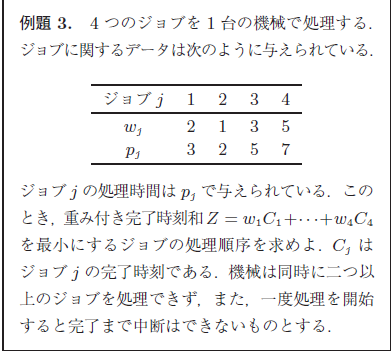

In [8]:
display_png(Image('pictures/ex3.PNG'))

最適順序は，4 -> 1 -> 3 -> 2（論文のものは誤植）

##### 定式化1

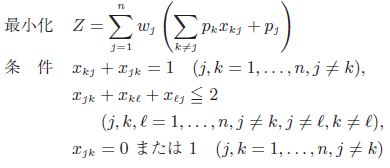

In [9]:
display_png(Image('pictures/formula3-1.PNG'))

In [10]:
prob = LpProblem(name='formula3-1', sense=LpMinimize)

# 定数
w = np.array([2, 1, 3, 5])
p = np.array([3, 2, 5, 7])
T = np.sum(p)
n = len(w)

# 変数
x = [[LpVariable(f"x{j},{k}", lowBound=0, cat="Binary") for k in range(n)] for j in range(n)]

# 目的関数
prob += lpSum(w[j] * (lpSum(p[k] * x[k][j] for k in range(n) if k != j) + p[j]) for j in range(n))

# 制約式
for j, k in product(range(n), (range(n))):
    if j != k:
        prob += x[k][j] + x[j][k] == 1
for j, k, l in product(range(n), range(n), range(n)):
    if j != k and j != l and k != l:
        prob += x[j][k] + x[k][l] + x[l][j] <= 2

# 求解
prob.solve()
print('Status: ', LpStatus[prob.status])
print(f'Optimal value = {value(prob.objective)}')
for v in prob.variables():
    print(f'{v}={value(v)}')

Status:  Optimal
Optimal value = 117.0
x0,1=1.0
x0,2=1.0
x0,3=0.0
x1,0=0.0
x1,2=0.0
x1,3=0.0
x2,0=0.0
x2,1=1.0
x2,3=0.0
x3,0=1.0
x3,1=1.0
x3,2=1.0


##### 定式化2

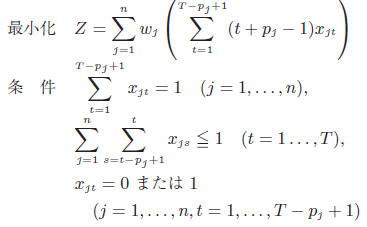

In [11]:
display_png(Image('pictures/formula3-2.PNG'))

※最適値はあっているが，最適解が変．print(prob)してみると，2番目の制約式のところがうまくいっていない

In [12]:
prob = LpProblem(name='formula3-2', sense=LpMinimize)

# 定数
w = np.array([2, 1, 3, 5])
p = np.array([3, 2, 5, 7])
T = np.sum(p) + np.max(p)
n = len(w)

# 変数
x = [[LpVariable(f"x{j},{t}", lowBound=0, cat="Binary") for t in range(T)] for j in range(n)]

# 目的関数
prob += lpSum(w[j] * lpSum((t+p[j]-1) * x[j][t] for t in range(T-p[j]+1)) for j in range(n))

# 制約式
for j in range(n):
    prob += lpSum(x[j][t] for t in range(T-p[j]+1)) == 1
for t in range(T):
    prob += lpSum(x[j][s] for s in range(t-p[j], t) for j in range(n) if t-p[j]>=0) <= 1

# 求解
prob.solve()
print('Status: ', LpStatus[prob.status])
print(f'Optimal value = {value(prob.objective)}')
for v in prob.variables():
    if value(v) != 0:
        print(f'{v}={value(v)}')

Status:  Optimal
Optimal value = 117.0
x0,14=1.0
x1,21=1.0
x2,7=1.0
x3,0=1.0


##### 定式化3

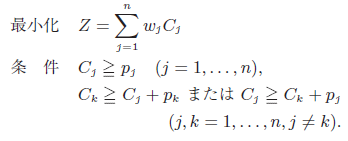

In [13]:
display_png(Image('pictures/formula3-3.PNG'))

In [14]:
prob = LpProblem(name='formula3-3', sense=LpMinimize)

# 定数
w = np.array([2, 1, 3, 5])
p = np.array([3, 2, 5, 7])
n = len(w)
M = 100

# 変数
C = [LpVariable(f"C{j}", lowBound=0, cat="Integer") for j in range(n)]
y = [[LpVariable(f"y{j},{k}", lowBound=0, cat="Binary") for k in range(n)] for j in range(n)]

# 目的関数
prob += lpSum(w[j] * C[j] for j in range(n))

# 制約式
for j in range(n):
    prob += C[j] >= p[j]

for j, k in product(range(n), range(n)):
    if j != k:
        prob += C[j] - C[k] + p[k] <= M * (1-y[j][k])
        prob += C[k] - C[j] + p[j] <= M * y[j][k]

# 求解
prob.solve()
print('Status: ', LpStatus[prob.status])
print(f'Optimal value = {value(prob.objective)}')
for v in prob.variables()[:4]:
    if value(v) != 0:
        print(f'{v}={value(v)}')

Status:  Optimal
Optimal value = 117.0
C0=10.0
C1=17.0
C2=15.0
C3=7.0


## 巡回セールスマン問題

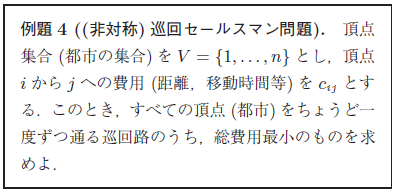

In [15]:
display_png(Image('pictures/ex4.PNG'))

##### 定式化

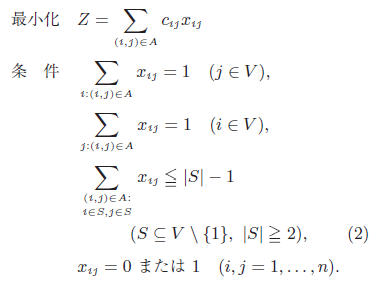

In [16]:
display_png(Image('pictures/formula4-1.PNG'))

素直に解こうとすると，部分巡回路除去制約の数が$O(2^n)$になるため，以下のようなアルゴリズムで解く
1. 部分巡回路除去制約なしの問題を解く
2. 最適解に対する巡回路が部分巡回路を持たなければ終了
3. そうでなければ，その部分巡回路をSとした部分巡回路除去制約を加えた問題を解く
4. 部分巡回路がなくなるまで繰り返し

In [2]:
MEPS = 1.0e-10

def solve_TSP(G, x, y):
    n = len(G.nodes())
    nodes = list(G.nodes())
    edges = [(nodes[i], nodes[j]) for i, j in product(range(n), range(n)) if nodes[i] < nodes[j]]
    D = np.sqrt((x.reshape(-1, 1) - x)**2 + (y.reshape(-1, 1) - y)**2)
    
    # 部分巡回路除去制約なしの最適化問題
    prob = LpProblem(name='TSP', sense=LpMinimize)
    # 変数：辺i, jが巡回路に含まれるなら1，そうでないなら0
    x = {(i, j): LpVariable(f'x{i}, {j}', lowBound=0, cat='Binary') for i, j in edges}
    prob += lpSum(D[i, j] * x[i, j] for i, j in edges)
    for i in range(n):
        edges_including_i = [(j, i) for j in nodes if (j, i) in edges] \
                             + [(i, j) for j in nodes if (i, j) in edges] 
        prob += lpSum(x[e] for e in edges_including_i) == 2
    prob.solve()
    
    # 連結成分が2つ以上あれば，それぞれの連結成分に対して，除去制約を入れて解き直す
    subtours = []
    for i, j in edges:
        if x[i, j].varValue > MEPS:
            subtours.append([i, j])
    G.add_edges_from(subtours)
    cc = list(nx.connected_components(G))
    while len(cc) > 1:
        for S in cc:
            prob += lpSum(x[i, j] for i, j in edges if i in S and j in S) <= len(S) - 1
        prob.solve()
    # 解の更新
        G.remove_edges_from(subtours)
        subtours = []
        for i, j in edges:
            if x[i, j].varValue > MEPS:
                subtours.append([i, j])
        G.add_edges_from(subtours)
        cc = list(nx.connected_components(G))
    
    len_tour = 0
    for i, j in G.edges():
        len_tour += D[i, j]
    
    return len_tour

C:\Users\kengo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


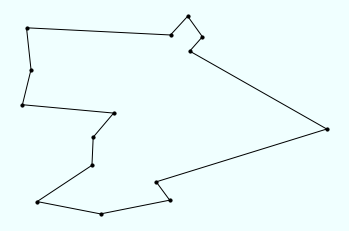

3212.900011212358


In [5]:
# n点からなるグラフの生成
n = 15
vlist = [i for i in range(n)]
Tours = nx.Graph()
Tours.add_nodes_from(vlist)
np.random.seed(7)
x = np.random.randint(low=0, high=1000, size=n)
y = np.random.randint(low=0, high=1000, size=n)
p = {i: (x[i], y[i]) for i in range(n)}

plt.figure(facecolor='azure')
opt_val = solve_TSP(Tours, x, y)
nx.draw_networkx(Tours, pos=p, node_color='k', node_size=10, with_labels=False)
plt.axis('off')
plt.show()

print(opt_val)

部分巡回路除去制約をMTZ制約に置き換えて求解する．制約式の本数は$O(n^2)$になるが，弱い定式化になる
* MTZ制約
    * 訪問順に昇順に番号を振っていく．起点に戻るときだけは降順になっても良いものとする
    * 閉路になっていれば最後だけは降順になるが，これが起点以外で発生することを禁止すれば部分巡回路を除去できる

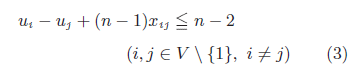

In [19]:
display_png(Image('pictures/formula4-2.PNG'))

In [20]:
def solve_TSP_MTZ(G, x, y):
    n = len(G.nodes())
    nodes = list(G.nodes())
    edges = [(nodes[i], nodes[j]) for i, j in product(range(n), range(n)) if nodes[i] != nodes[j]]
    D = np.sqrt((x.reshape(-1, 1) - x)**2 + (y.reshape(-1, 1) - y)**2)
    
    prob = LpProblem(name='TSP', sense=LpMinimize)
    # 変数：ノードiからノードjに移動するなら1，そうでないなら0
    x = {(i, j): LpVariable(f'x{i}, {j}', lowBound=0, cat='Binary') for i, j in edges}
    u = {i: LpVariable(f'u{i}', lowBound=1, upBound=n) for i in nodes}
    
    prob += lpSum(D[i, j] * x[i, j] for i, j in edges)
    for i in range(n):
        prob += lpSum(x[i, j] for j in range(n) if i != j) == 1
    for i in range(n):
        prob += lpSum(x[j, i] for j in range(n) if i != j) == 1
    for i in range(n):
        for j in range(1, n):
            if i != j:
                prob += u[i] + 1 - (n-1) * (1-x[i, j]) <= u[j]
    
    prob.solve()
    
    subtours = []
    for i, j in edges:
        if x[i, j].varValue > MEPS:
            subtours.append([i, j])
    G.add_edges_from(subtours)

    len_tour = 0
    for i, j in G.edges():
        len_tour += D[i, j]
    
    return len_tour    

C:\Users\kengo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


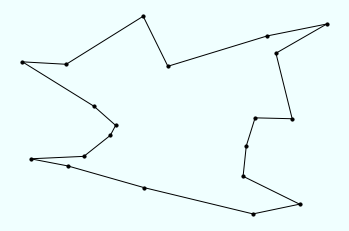

3757.277080174551


In [26]:
# n点からなるグラフの生成
n = 20
vlist = [i for i in range(n)]
Tours = nx.Graph()
Tours.add_nodes_from(vlist)
np.random.seed(1234)
x = np.random.randint(low=0, high=1000, size=n)
y = np.random.randint(low=0, high=1000, size=n)
p = {i: (x[i], y[i]) for i in range(n)}

plt.figure(facecolor='azure')
opt_val = solve_TSP_MTZ(Tours, x, y)
nx.draw_networkx(Tours, pos=p, node_color='k', node_size=10, with_labels=False)
plt.axis('off')
plt.show()

print(opt_val)